In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
import gensim.corpora as corpora
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

import gensim
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
data = pd.read_csv("/content/QueryResults_Clear.csv",
                   converters={"title": literal_eval,
                               "body": literal_eval,
                               "tags": literal_eval})
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,body,tags
0,"[memory, gpus, model]","[gpus, gpu, image, memory, error, memory, imag...",[python]
1,[ubuntu],"[xampp, server, command, xampp, command, result]",[php]
2,"[prop, value, input, redux, react]","[input, field, form, button, field, redux, dif...",[react-native]
3,"[cs, j, web, application, servlet]","[project, structure, intellij, idea, java, web...","[javascript, java, css]"
4,"[factor, analysis, array, dataframe]","[factor, analysis, lib, result, array, number,...",[python]


In [3]:
Xall = data['body'] + data['title']

Y = data['tags']
# Binarise multilabel
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(Y)
Y_multi = multilabel_binarizer.transform(Y)

Xall

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        [gpus, gpu, image, memory, error, memory, imag...
1        [xampp, server, command, xampp, command, resul...
2        [input, field, form, button, field, redux, dif...
3        [project, structure, intellij, idea, java, web...
4        [factor, analysis, lib, result, array, number,...
                               ...                        
38014    [device, proxy, select, wifi, option, proxy, p...
38015    [text, array, yearmonthdate, javascripti, text...
38016    [chess, game, vector, vector, chess, piece, cl...
38017    [payment, gateway, django, zeep, module, payme...
38018    [spring, mvc, project, inteij, idea, english, ...
Length: 38019, dtype: object

In [4]:
#Init TFIDF vector
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)
vectorizer.fit(Xall)
X_tfidf = vectorizer.transform(Xall)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
X_tfidf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<38019x476 sparse matrix of type '<class 'numpy.float64'>'
	with 419286 stored elements in Compressed Sparse Row format>

In [6]:
tfidf_tokens = vectorizer.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = X_tfidf.toarray(),columns = tfidf_tokens)
print("\nTD-IDF Vectorizer\n")
print(df_tfidfvect.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



TD-IDF Vectorizer

   access  account    action  activity  address  admin  advance  advice   
0     0.0      0.0  0.000000       0.0      0.0    0.0      0.0     0.0  \
1     0.0      0.0  0.000000       0.0      0.0    0.0      0.0     0.0   
2     0.0      0.0  0.336789       0.0      0.0    0.0      0.0     0.0   
3     0.0      0.0  0.000000       0.0      0.0    0.0      0.0     0.0   
4     0.0      0.0  0.000000       0.0      0.0    0.0      0.0     0.0   

   algorithm  amount  ...  widget  width  window  word  work  workaround   
0        0.0     0.0  ...     0.0    0.0     0.0   0.0   0.0         0.0  \
1        0.0     0.0  ...     0.0    0.0     0.0   0.0   0.0         0.0   
2        0.0     0.0  ...     0.0    0.0     0.0   0.0   0.0         0.0   
3        0.0     0.0  ...     0.0    0.0     0.0   0.0   0.0         0.0   
4        0.0     0.0  ...     0.0    0.0     0.0   0.0   0.0         0.0   

   working  wrong  xml  year  
0      0.0    0.0  0.0   0.0  
1      0.0

In [7]:
# Bag of words
bagOfWords = corpora.Dictionary(Xall)
bagOfWords.filter_extremes(no_below=4, no_above=0.6, keep_n=None)

# Term Document Frequency 
corpus = [bagOfWords.doc2bow(text) for text in Xall]  
# View 
print(Xall[:1])
[[(bagOfWords[id], freq) for id, freq in cp] for cp in corpus[:1]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    [gpus, gpu, image, memory, error, memory, imag...
dtype: object


[[('error', 1),
  ('gpu', 1),
  ('gpus', 3),
  ('image', 3),
  ('input', 1),
  ('memory', 4),
  ('model', 1),
  ('thing', 1),
  ('way', 1)]]

In [8]:
metricsEval = pd.DataFrame(columns=["nom","Accuracy","Jaccard","Precision"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# calcul de metrics
def calculMetric(model,y,y_pred):
    locData = [model]
    acc = metrics.accuracy_score(y,y_pred)
    locData.append(acc)
    jac = metrics.jaccard_score(y,y_pred,average='weighted')
    locData.append(jac)
    prec = metrics.precision_score(y,y_pred,average='weighted')
    locData.append(prec)
    
    metricsEval.loc[len(metricsEval)]=locData

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**LDA**

In [10]:
lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=bagOfWords,
                                  num_topics=20,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Calculate Document/topic matrix with Gensim
doc_topic = pd.DataFrame(lda_model.get_document_topics(corpus,
                                                  minimum_probability=0))
for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Matricial multiplication with Document / Topics transpose
topic_tag = np.matmul(doc_topic.T, Y_multi)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
y_results = pd.DataFrame(Y)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["tags"].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(Y_multi)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: ignored

In [13]:
# Select predicted tags in Topics / Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# Create matrix for pred and true y LDA
lda_y_pred = np.zeros(Y_multi.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(Y_multi.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
print(y_results[0:5])

                      tags  best_topic  nb_tags       y_true        y_pred
0                 [python]          15        1         [26]          [34]
1                    [php]          15        1         [24]          [34]
2           [react-native]          10        1         [29]          [26]
3  [javascript, java, css]          12        3  [7, 16, 17]  [26, 17, 16]
4                 [python]          13        1         [26]          [26]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
calculMetric("LDA",lda_y_true,lda_y_pred)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.092253 -0.083270       1        1  10.798666
1     -0.114923  0.011007       2        1   7.169132
2      0.027922 -0.013687       3        1   6.386509
0      0.052106 -0.003153       4        1   5.735421
14    -0.086581  0.008501       5        1   5.684273
10     0.036656 -0.014466       6        1   5.423795
15    -0.054322 -0.052702       7        1   5.383866
12    -0.064342  0.004377       8        1   5.367943
9      0.092200  0.092880       9        1   5.354545
6     -0.035420  0.028612      10        1   4.801734
4      0.040365  0.016112      11        1   4.767533
18    -0.003762  0.065513      12        1   4.343612
11     0.007763  0.036505      13        1   4.319157
17    -0.002023  0.054696      14        1   4.312039
3     -0.050709 -0.070972      15        1   3.882345
16     0.007049 -0.059532      16        1   3.669134
19    -0.010677  0.006256      17        1   3.560460
7      0.026587 -0.027216      18        1   3.239493
8     -0.007491  0.043086      19        1   3.075066
5      0.047349 -0.042546      20        1   2.725276, topic_info=         Term          Freq         Total Category  logprob  loglift
31       file  16464.000000  16464.000000  Default  30.0000  30.0000
140      data  14488.000000  14488.000000  Default  29.0000  29.0000
161  function  11604.000000  11604.000000  Default  28.0000  28.0000
91     column   8057.000000   8057.000000  Default  27.0000  27.0000
126   element   4629.000000   4629.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
182   example    168.528473   6328.565893  Topic20  -4.9990  -0.0231
8         way    176.453414   9292.949813  Topic20  -4.9531  -0.3614
130    string    155.365297   5120.213759  Topic20  -5.0804   0.1074
3       image    160.671812   6268.548421  Topic20  -5.0468  -0.0613
101     class    153.458310   7401.150104  Topic20  -5.0927  -0.2734

[1703 rows x 6 columns], token_table=      Topic      Freq Term
term                      
3880      5  0.136717  aac
3880     15  0.683585  aac
5343     17  0.879369  aad
177       1  0.092640  abc
177       3  0.023160  abc
...     ...       ...  ...
1414     14  0.004012  zip
1414     17  0.020060  zip
1414     18  0.004012  zip
1414     19  0.012036  zip
1414     20  0.020060  zip

[9486 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 2, 3, 1, 15, 11, 16, 13, 10, 7, 5, 19, 12, 18, 4, 17, 20, 8, 9, 6])

In [15]:
# Create train and test split (80%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y_multi,
                                                    test_size=0.2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Regression multi logistique

In [19]:
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)

multi_logit_cv.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [20]:
X_train.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(30415, 476)

In [21]:
print(multi_logit_cv.best_params_)

{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Predict
y_pred_logreg = multi_logit_cv.predict(X_test)
# Inverse transform
y_pred_inversed = multilabel_binarizer.inverse_transform(y_pred_logreg)
y_inversed = multilabel_binarizer.inverse_transform(y_test)

print("Prédiction")
print(y_pred_inversed[5:10])
print('-'*30)
print("Réel")
print(y_inversed[5:10])

Prédiction
[(), ('jquery',), (), (), ()]
------------------------------
Réel
[('node.js', 'reactjs'), ('jquery',), ('javascript',), ('java',), ('angular', 'javascript', 'typescript')]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
calculMetric("RegLog",y_test,y_pred_logreg)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
print(metricsEval)
print(metricsEval[metricsEval['nom']=='LDA'].iloc[:,1:])

      nom  Accuracy   Jaccard  Precision
0     LDA  0.112838  0.078382   0.207996
1  RegLog  0.252893  0.343925   0.719528
   Accuracy   Jaccard  Precision
0  0.112838  0.078382   0.207996


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Random **Forest**

In [16]:
from sklearn.ensemble import RandomForestClassifier
# Initialize RandomForest with OneVsRest
param_rfc = {"estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=2,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on Sample data
multi_rfc_cv.fit(X_train[0:5000], y_train[0:5000])

Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [17]:
rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 5, 'estimator__min_samples_leaf': 5}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
rfc_best_params_ok = {}
for k, v in rfc_best_params.items():
    rfc_best_params_ok[k.replace("estimator__","")] = v

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Refit RandomForestClassifier best_params with full dataset
rfc_final_model = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model.fit(X_train, y_train)

# Prediction
y_test_predicted_labels_tfidf_rfc = rfc_final_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf_rfc)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)
print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc[0:5])
print("True:", y_test_inversed[0:5])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('arrays', 'javascript', 'json'), ('c++', 'python', 'python-3.x'), ('dataframe', 'excel', 'python-3.x', 'r'), ('#', 'c', 'java', 'postgresql', 'sql', 'sql-server'), ('arrays', 'javascript', 'typescript')]
True: [('json',), ('python',), ('#', 'c'), ('#', 'c'), ('react-native', 'reactjs')]


In [21]:
calculMetric("RDForest",y_test,y_test_predicted_labels_tfidf_rfc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
print(metricsEval[metricsEval['nom']=='RDForest'].iloc[:,1:])

   Accuracy   Jaccard  Precision
0  0.049711  0.297923   0.350616


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
Tags_per_row_lmr = y_pred_logreg.sum(axis=1)
null_rate_lr = round(((Tags_per_row_lmr.size - np.count_nonzero(Tags_per_row_lmr))
                      /Tags_per_row_lmr.size)*100,2)
Tags_per_row_RF = y_test_predicted_labels_tfidf_rfc.sum(axis=1)
null_rate_rf = round(((Tags_per_row_RF.size - np.count_nonzero(Tags_per_row_RF))
                      /Tags_per_row_RF.size)*100,2)
print("-"*50)
print("Percentage des questions non classifiées pour chaque modèle")
print("-" * 50)
print("Regression multi logistique: {}%".format(null_rate_lr))
print("Random Forest: {}%".format(null_rate_rf))

--------------------------------------------------
Percentage des questions non classifiées pour chaque modèle
--------------------------------------------------
Regression multi logistique: 42.89%
Random Forest: 5.92%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


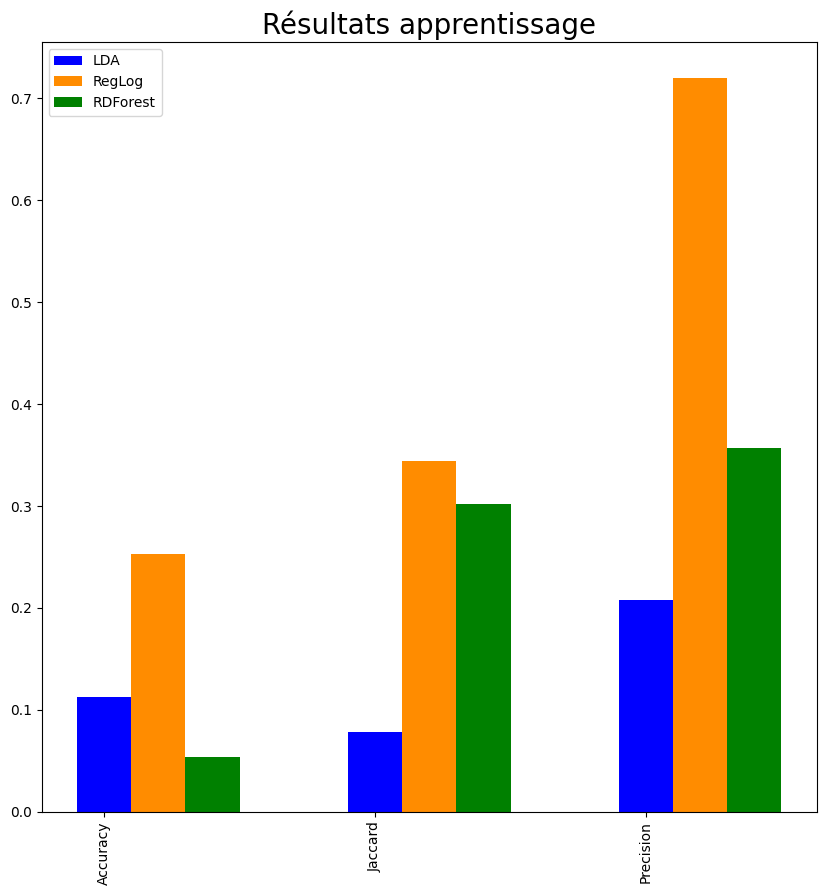

In [32]:
x = np.arange(metricsEval.shape[1]-1)
width = 0.2
fsize = (10,10)

fig, ax = plt.subplots(1,1,figsize=fsize)
rects1 = ax.bar(x,metricsEval[metricsEval['nom']=='LDA'].iloc[:,1:].squeeze(),width,color='blue')
rects2 = ax.bar(x+ width,metricsEval[metricsEval['nom']=='RegLog'].iloc[:,1:].squeeze(),width,color='darkorange')
rects3 = ax.bar(x+ width+width,metricsEval[metricsEval['nom']=='RDForest'].iloc[:,1:].squeeze(),width,color='green')
ax.set_title('Résultats apprentissage', fontsize=20)
plt.xticks(x, ['Accuracy', 'Jaccard','Precision'], rotation='vertical')
ax.legend((rects1[0], rects2[0],rects3[0]), metricsEval['nom'])
plt.show()

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
import re
import string
import seaborn as sns
from wordcloud import WordCloud
import spacy
from bs4 import BeautifulSoup
from tqdm import tqdm
tqdm.pandas()
test_doc='returning a value from within a nested javascript function duplicate '
df = pd.DataFrame({'question': [test_doc]})
df
def nettoyageGe(listToClean):
    
    # Lower case
    locList = listToClean.lower()

    # Remove ponctuation sauf #
    locList = re.sub('[^\\w\\s#]', '', locList)
    # Remove digit
    locList = re.sub(r'\w*\d+\w*', '', locList)
    # Remove links
    locList = re.sub(r'http*\S+', '', locList)
    # Remove \n
    locList = locList.replace("\n"," ")
    # Change some words
    locList = locList.replace("i'm","i am")
    locList = locList.replace("i've","i have")
    locList = locList.replace("i'd","i would")
    locList = locList.replace("don't","do not")
    locList = locList.replace("that's","that is")
    # On supprime les espaces en trop
    locList=" ".join(locList.split())
    locList = locList.replace("c #","c#")
    locList = locList.replace("c#","cSharp")
    
    return(locList)
def getWord(listToWork):
    """ 
    Fonction qui compte le nombre de mots différents
    listToWork : Dataframe
    """
    motList=[]
    tempData = df[listToWork].copy()
    
    for listData in tempData:
        for mot in listData:
            motList.append(mot)
            
    dfMotList = pd.DataFrame(motList, columns=["Mot"])
    dfMotList = dfMotList.groupby("Mot")\
        .agg(Count=pd.NamedAgg(column="Mot", aggfunc="count"))
    dfMotList.sort_values("Count", ascending=False, inplace=True)
    
    return dfMotList
# Supprimer les tag <code>
def SuppCode(x):
    soup = BeautifulSoup(x,"html.parser")
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return str(soup)
# Regrouper c et #
def RegCSharp(x):
    test = x.copy()
    while '#' in test : 
        idx = test.index('#')
        if(test[idx-1]=='c'):
            test[idx]="c#"
            del(test[idx-1])
        else:
            del(test[idx])
    return(test)
# Delete htlm et code tags
df['question'] = df['question'].apply(SuppCode)
# Delete all html tags
df['question'] = [BeautifulSoup(text,"html.parser").get_text() for text in df['question']]
nlp = spacy.load('en_core_web_sm')
pos_list = ["NOUN","PROPN"]
# On garde nom et prono
def keepNomEtPronom(info):
    doc = nlp(info)
    list_text_row = []
    for token in doc:
        if(token.pos_ in pos_list):
            list_text_row.append(token.text)
    list_text = " ".join(list_text_row)
    list_text = list_text.replace("c #", "c#")
    list_text_row = []
    return list_text
#Nettoyage général
df['question'] = df['question'].progress_apply(lambda x : nettoyageGe(x))
df['question'] = df['question'].progress_apply(lambda x : keepNomEtPronom(x))
import nltk
nltk.download('punkt')
# Tokenization
df['question'] = df['question'].apply(nltk.tokenize.word_tokenize)

df['question']=df['question'].apply(lambda x : RegCSharp(x))
import nltk
nltk.download('wordnet')
# Lemmatizer
wn = nltk.WordNetLemmatizer()
df['question'] = df['question'].apply(lambda x : [wn.lemmatize(word) for word in x])
import nltk
nltk.download('stopwords')
# StopWords
sw = set()
sw.update(tuple(nltk.corpus.stopwords.words('english')))

df['question'] = df['question'].apply(lambda x : [mot for mot in x
                       if mot not in sw])
print(df['question'].head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 1/1 [00:00<00:00, 24.53it/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


0    [value, javascript, function, duplicate]
Name: question, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
def predire(text):
  df = pd.DataFrame({'question': [text]})
  df['question'] = df['question'].apply(SuppCode)
  df['question'] = [BeautifulSoup(text,"html.parser").get_text() for text in df['question']]
  df['question'] = df['question'].progress_apply(lambda x : nettoyageGe(x))
  df['question'] = df['question'].progress_apply(lambda x : keepNomEtPronom(x))
  df['question'] = df['question'].apply(nltk.tokenize.word_tokenize)
  df['question']=df['question'].apply(lambda x : RegCSharp(x))
  wn = nltk.WordNetLemmatizer()
  df['question'] = df['question'].apply(lambda x : [wn.lemmatize(word) for word in x])
  sw = set()
  sw.update(tuple(nltk.corpus.stopwords.words('english')))

  df['question'] = df['question'].apply(lambda x : [mot for mot in x
                       if mot not in sw])
  X_tfidf = vectorizer.transform(df['question'])
  predict = rfc_final_model.predict(X_tfidf)
  # Inverse multilabel binarizer
  tags_predict = multilabel_binarizer.inverse_transform(predict)
  return tags_predict


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


[('arrays', 'html', 'javascript')]


In [28]:
#Simulation
text = 'how to create json file based on pandas dataframe python '
print(predire(text))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 1/1 [00:00<00:00, 19.68it/s]


[('dataframe', 'json', 'pandas', 'python', 'python-3.x')]
